# Classify MNIST digits with dense network

In [27]:
import os
import numpy as np
import mindspore as ms
import mindspore.nn as nn
from mindspore.dataset import vision
from mindspore import Model
from mindspore.train.callback import Callback
from mindspore.train.callback import LossMonitor
import mindspore.dataset as ds
import matplotlib.pyplot as plt

## set same seed for reproducibility

In [28]:
# set same seed
np.random.seed(777)
ms.set_seed(777)

## hyperparameters

In [29]:
batch_size = 32
epoch_size = 10
learning_rate = 0.01

## dataset loading

load MNIST dataset

In [30]:
dataset_dir = "./MNIST"

6 3 7 9 1 5 9 3 5 

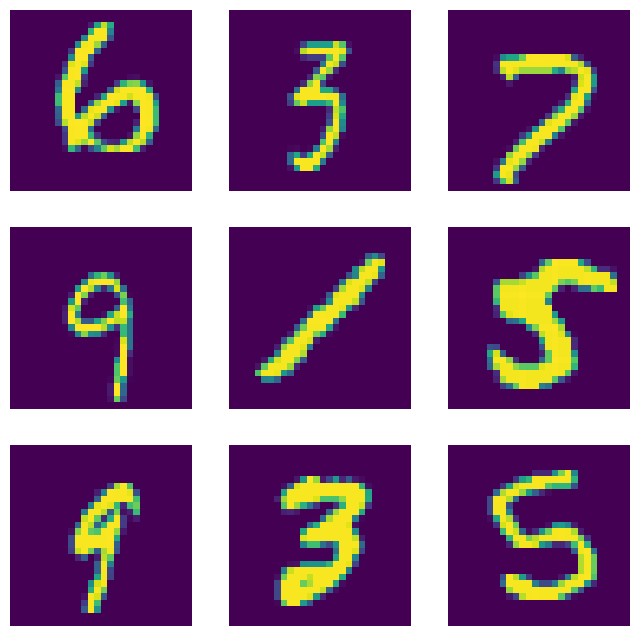

In [31]:
# 从 mnist dataset 读取 3 张图片
train_dataset = ds.MnistDataset(dataset_dir=os.path.join(dataset_dir, "train"), shuffle=True)
test_dataset = ds.MnistDataset(dataset_dir=os.path.join(dataset_dir, "test"), shuffle=False)

# 打印 9 张子图
plt.figure(figsize=(8,8))
i=1
for dic in train_dataset.create_dict_iterator(output_numpy=True):
    plt.subplot(3,3,i)
    plt.imshow(dic['image'][:,:,0])
    plt.axis('off')
    print(dic['label'],end=' ')
    i +=1
    if i>9:
        break

plt.show()

In [32]:
# convert label to float32, and resize label to (batch_size, 1)
train_dataset = train_dataset.batch(batch_size=batch_size,drop_remainder=True)
train_dataset = train_dataset.map(operations=ds.transforms.TypeCast(ms.dtype.int32), input_columns="label", num_parallel_workers=1)
train_dataset = train_dataset.map(vision.Rescale(1.0 / 255.0, 0), input_columns='image')

test_dataset = test_dataset.map(vision.Rescale(1.0 / 255.0, 0), input_columns='image')
test_dataset = test_dataset.map(operations=ds.transforms.TypeCast(ms.dtype.int32), input_columns="label", num_parallel_workers=1)
test_dataset = test_dataset.batch(batch_size=batch_size,drop_remainder=False)

image, label = next(train_dataset.create_tuple_iterator())
print(train_dataset.get_dataset_size())
print(image.shape, image.dtype)
print(label.shape, label.dtype)


1875
(32, 28, 28, 1) Float32
(32,) Int32


## network definition

In [33]:
class DenseNetwork(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 256),
            nn.ReLU(),
            nn.Dense(256, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits


## model training and evaluation

model compilation

In [34]:
net = DenseNetwork()
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optim = nn.Momentum(params=net.trainable_params(), learning_rate=learning_rate, momentum=0.9)
model = Model(network = net, loss_fn=loss, optimizer=optim, metrics={"Accuracy": nn.Accuracy()})


In [35]:
config_ck = ms.CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint = ms.ModelCheckpoint(prefix="dense", directory="./model/dense_model", config=config_ck)


In [36]:
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps_loss = steps_loss
        self.steps_eval = steps_eval

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])

training

In [37]:
# training
steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
# collect the steps,loss and accuracy information
step_loss_acc_info = StepLossAccInfo(model, test_dataset, steps_loss, steps_eval)
model.train(epoch=epoch_size, train_dataset=train_dataset,callbacks=[ckpoint, LossMonitor(700), step_loss_acc_info], dataset_sink_mode=False)


[WARNING] ME(25820:45696,MainProcess):2023-05-22-19:45:07.821.28 [mindspore\train\model.py:1077] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 700, loss is 0.6892787218093872
epoch: 1 step: 1400, loss is 0.04462600126862526
epoch: 2 step: 225, loss is 0.14007680118083954
epoch: 2 step: 925, loss is 0.17901799082756042
epoch: 2 step: 1625, loss is 0.1358441710472107
epoch: 3 step: 450, loss is 0.18949316442012787
epoch: 3 step: 1150, loss is 0.05595208331942558
epoch: 3 step: 1850, loss is 0.117508664727211
epoch: 4 step: 675, loss is 0.053377002477645874
epoch: 4 step: 1375, loss is 0.03793356940150261
epoch: 5 step: 200, loss is 0.027835819870233536
epoch: 5 step: 900, loss is 0.018584612756967545
epoch: 5 step: 1600, loss is 0.02453513629734516
epoch: 6 step: 425, loss is 0.06250058114528656
epoch: 6 step: 1125, loss is 0.0423603355884552
epoch: 6 step: 1825, loss is 0.17656484246253967
epoch: 7 step: 650, loss is 0.14050541818141937
epoch: 7 step: 1350, loss is 0.0017029806040227413
epoch: 8 step: 175, loss is 0.010486207902431488
epoch: 8 step: 875, loss is 0.011649230495095253
epoch: 8 step: 1575, loss is 

## test

In [38]:
def test_net(network, model):
    """Define the evaluation method."""
    # load the saved model for evaluation
    param_dict = ms.load_checkpoint("./model/dense_model/dense-1_1875.ckpt")
    # load parameter to the network
    ms.load_param_into_net(network, param_dict)
    # evaluation
    acc = model.eval(test_dataset, dataset_sink_mode=False)
    print("============== Accuracy:{} ==============".format(acc))

test_net(net, model)

============== Accuracy:{'Accuracy': 0.9437} ==============


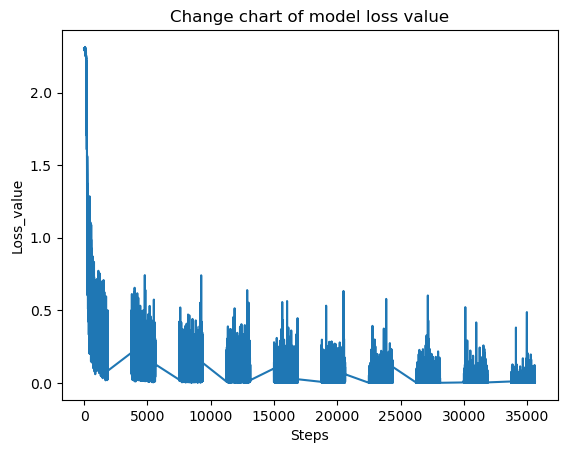

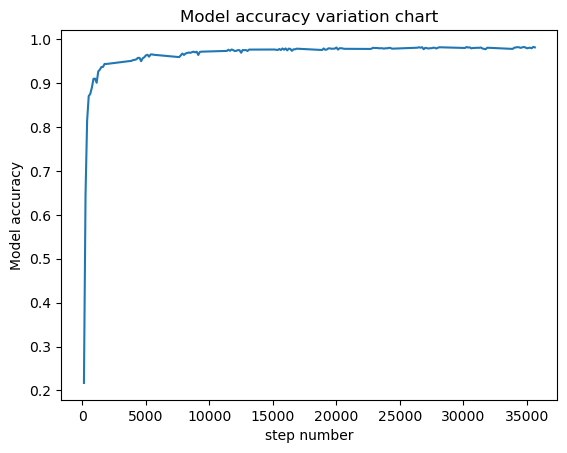

In [39]:
## show loss
steps = steps_loss["step"]
loss_value = steps_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))

plt.figure()
plt.plot(steps, loss_value)
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Change chart of model loss value")

plt.figure()
plt.xlabel("step number")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(steps_eval["step"], steps_eval["acc"])
plt.show()